In [1]:
import numpy as np
import pyarrow
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pyspark.sql import SparkSession

In [2]:
# Spark 세션 생성
spark = SparkSession.builder \
    .appName("HDFS Parquet Data Analysis") \
    .getOrCreate()

# HDFS에 있는 Parquet 파일의 경로
hdfs_path = "hdfs://hadoop-master:9000/user/root/data/yellow_tripdata_2024-01.parquet"

# HDFS에서 Parquet 파일을 읽어 Spark DataFrame으로 로드
df = spark.read.parquet(hdfs_path)

# DataFrame을 RDD로 변환
rdd = df.rdd

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/11 14:00:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
rdd.take(1)

[Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2024, 1, 1, 0, 57, 55), tpep_dropoff_datetime=datetime.datetime(2024, 1, 1, 1, 17, 43), passenger_count=1, trip_distance=1.72, RatecodeID=1, store_and_fwd_flag='N', PULocationID=186, DOLocationID=79, payment_type=2, fare_amount=17.7, extra=1.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=1.0, total_amount=22.7, congestion_surcharge=2.5, Airport_fee=0.0)]

In [4]:
vendors = [1, 2]
ratecodes = [1,2,3,4,5,6]
payments = [1, 2, 3, 4, 5, 6]

# 잘못된 데이터(행) 제거
def cleaning(row):
    # 각 필드에 대해 결측값을 처리
    if row['VendorID'] not in vendors: return False
    if row['passenger_count'] < 1: return False
    if row['trip_distance'] <= 0: return False
    if row['RatecodeID'] not in ratecodes: return False
    if row['payment_type'] not in payments: return False
    if row['fare_amount'] <= 0: return False
    if row['extra'] < 0: return False
    if row['mta_tax'] < 0: return False
    if row['tip_amount'] < 0: return False
    if row['tolls_amount'] < 0: return False
    if row['improvement_surcharge'] < 0: return False
    if row['total_amount'] <= 0: return False
    if row['congestion_surcharge'] <= 0: return False
    if row['Airport_fee'] < 0: return False
    return True

In [5]:
def remove_none_value(row):
    for val in row:
        if val is None:
            return
    return row

In [6]:
# None 거르기, 각 컬럼별 특이값 필터링
print(rdd.count())
filtered_1 = rdd.filter(lambda x: remove_none_value(x))
print(filtered_1.count())

2964624


2824462


In [7]:
filtered_2 = filtered_1.filter(cleaning)

In [8]:
filtered_2.take(5)

[Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2024, 1, 1, 0, 57, 55), tpep_dropoff_datetime=datetime.datetime(2024, 1, 1, 1, 17, 43), passenger_count=1, trip_distance=1.72, RatecodeID=1, store_and_fwd_flag='N', PULocationID=186, DOLocationID=79, payment_type=2, fare_amount=17.7, extra=1.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=1.0, total_amount=22.7, congestion_surcharge=2.5, Airport_fee=0.0),
 Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2024, 1, 1, 0, 3), tpep_dropoff_datetime=datetime.datetime(2024, 1, 1, 0, 9, 36), passenger_count=1, trip_distance=1.8, RatecodeID=1, store_and_fwd_flag='N', PULocationID=140, DOLocationID=236, payment_type=1, fare_amount=10.0, extra=3.5, mta_tax=0.5, tip_amount=3.75, tolls_amount=0.0, improvement_surcharge=1.0, total_amount=18.75, congestion_surcharge=2.5, Airport_fee=0.0),
 Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2024, 1, 1, 0, 17, 6), tpep_dropoff_datetime=datetime.datetime(2024, 1, 

In [9]:
# 평균값 계산 (미리 계산해둠)
avg_passenger_count = filtered_2.map(lambda row: row['passenger_count']).filter(lambda x: x is not None).mean()
avg_trip_distance = filtered_2.map(lambda row: row['trip_distance']).filter(lambda x: x is not None).mean()

print(avg_passenger_count)
print(avg_trip_distance)

1.3573798238471222
2.8602963300102937


In [10]:
# 날짜 유효성 검사 (픽업 시간이 드롭오프 시간보다 이전인지 확인)
rdd = filtered_2.filter(lambda row: row[2] > row[1])

In [11]:
# 평균 여행 시간 계산
rdd = rdd.map(lambda row: row + (row[2].timestamp() - row[1].timestamp(),))

In [12]:
rdd.take(1)

[(2,
  datetime.datetime(2024, 1, 1, 0, 57, 55),
  datetime.datetime(2024, 1, 1, 1, 17, 43),
  1,
  1.72,
  1,
  'N',
  186,
  79,
  2,
  17.7,
  1.0,
  0.5,
  0.0,
  0.0,
  1.0,
  22.7,
  2.5,
  0.0,
  1188.0)]

In [13]:

# 평균 계산
mean_travel_time = rdd.map(lambda row: row[19]).mean()
print(f"Mean Travel Time: {mean_travel_time} seconds")

Mean Travel Time: 893.8940713239328 seconds


In [14]:

# 평균 여행 거리 계산
mean_trip_distance = rdd.map(lambda row: row[4]).mean()
print(f"Mean Trip Distance: {mean_trip_distance} miles")

Mean Trip Distance: 2.860290679321089 miles


In [15]:

# 시간별 여행 수 계산
def extract_hour(row):
    hour = row[1].hour
    return (hour, 1)

hourly_trips_rdd = rdd.map(extract_hour).reduceByKey(lambda a, b: a + b)


In [16]:
hourly_trips_rdd.take(4)

[(0, 62979), (8, 96749), (16, 165842), (17, 180149)]

In [17]:

# 특정 일에 대한 시간 단위 여행 수
specific_day = '2024-01-30'

def filter_day(row):
    return row[1].date() == pd.to_datetime(specific_day).date()

filtered_rdd = rdd.filter(filter_day)
hourly_trips_specific_day_rdd = filtered_rdd.map(extract_hour).reduceByKey(lambda a, b: a + b)


In [18]:
hourly_trips_specific_day_rdd.take(1)

[(0, 1313)]

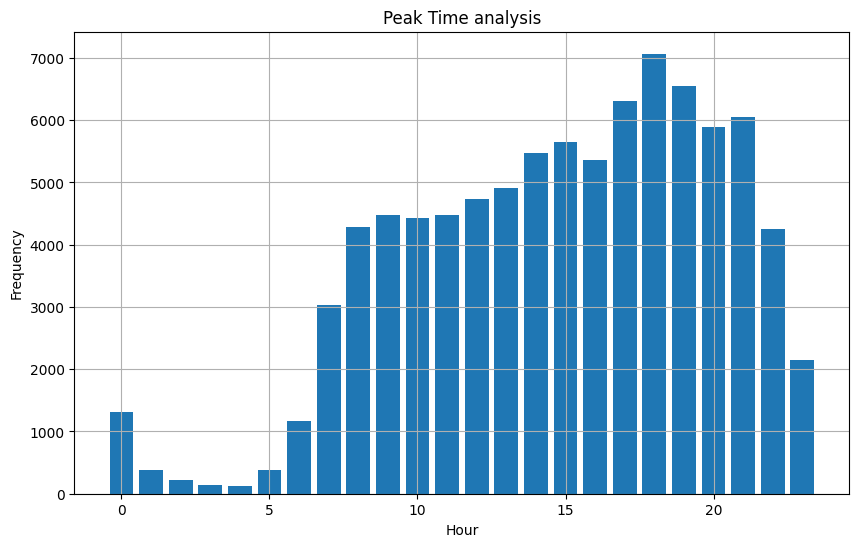

In [19]:

# RDD 데이터를 Pandas DataFrame으로 변환하여 시각화
hourly_trips_pandas = pd.DataFrame(hourly_trips_specific_day_rdd.collect(), columns=['hour', 'count'])

plt.figure(figsize=(10, 6))
plt.bar(hourly_trips_pandas['hour'], hourly_trips_pandas['count'])
plt.title('Peak Time analysis')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [20]:

# Parquet 형식으로 HDFS에 저장
output_path = 'hdfs://hadoop-master:9000/user/root/output/result_rdd.parquet'
rdd.toDF().write.parquet(output_path)

print(f'RDD-based Spark DataFrame successfully saved to HDFS at {output_path}')


AnalysisException: [PATH_ALREADY_EXISTS] Path hdfs://hadoop-master:9000/user/root/output/result_rdd.parquet already exists. Set mode as "overwrite" to overwrite the existing path.